# Random Forest Classifier 

In [1]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# from sklearn.ensemble import ExtraTreesClassifier # for future work
# from sklearn.tree import DecisionTreeClassifier # for future work
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_recall_curve, f1_score, precision_score, recall_score, 
                            classification_report, multilabel_confusion_matrix, mean_squared_error, mean_absolute_error)
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
import numpy as np
import glob, json

In [2]:
# Load file names and labels for the processed data
data_folder_prefix = "../Seg_Featured_Data/Seg_Featured_"

with open("../data_labels.json", 'r') as json_file:
    label_dict = json.load(json_file)


file_names = list(label_dict.keys())
print(len(file_names))

labels = []
for fl in file_names:
    labels.append(label_dict[fl])
print(len(labels))

743
743


In [4]:
files = [data_folder_prefix+x+".npy" for x in file_names]

ct, values = np.unique(labels, return_counts=True)
print(ct, values, values/values.sum())

pred = [4]* len(files)
accuracy_score(labels, pred)

[0 1 2 3 4] [ 35  15  30 142 521] [0.04710633 0.02018843 0.04037685 0.19111709 0.70121131]


0.7012113055181696

In [4]:
# # files = glob.glob("Seg_Featured_Data/*.npy")
# max_len = 250*250*9
# skip = 0
# flattened_test_load = np.zeros((max_len, ))
# print(flattened_test_load.shape)
# for fl in files:
#     test_load = np.load(fl, None, allow_pickle=True)
#     # Ignore depth 0
#     # Keep all Depth 1
#     # 
#     t = test_load.flatten()
#     t[t == np.inf] = 0.0
#     t[t == -np.inf] = 0.0
#     # print((t.shape[0]))
#     if t.shape[0] < max_len:
#         t= np.append(t,  [0]*(max_len-t.shape[0]), axis=0)
#         skip += 1

#     # flattened_test_load.append(np.float32(t))
#     flattened_test_load = np.vstack((flattened_test_load, t))

# print(flattened_test_load.shape,flattened_test_load[0].shape, "num padded:", skip)

# flattened_data = flattened_test_load[1:,:]
# flattened_data.shape, len(labels)


(562500,)
(744, 562500) (562500,) num padded: 106


In [24]:
# Revised 

# files = glob.glob("Seg_Featured_Data/*.npy")
max_len = 250*250+7
num_padded = 0
flattened_test_load = np.zeros((max_len, ))
print(flattened_test_load.shape)

for fl in files:
    test_load = np.load(fl, None, allow_pickle=True)
    y,x,_ = test_load.shape

    # Ignore depth 0
    # Keep all Depth 1
    #  if the x,y is less than 250x50 pad w 0s
    layers_depth = test_load[:,:,1]
    # print(layers_depth.shape)
    if x < 250:
        layers_depth = np.hstack((layers_depth, np.zeros((y, y-x))))
        num_padded +=1
    if y < 250:
        layers_depth = np.hstack((layers_depth, np.zeros((250-y, 250))))
    layers_depth = layers_depth.flatten()
    # print(layers_depth.shape)


    # Get the metrics from the other depths
    vl, ct = np.unique(test_load[:,:,5], return_counts=True)
    if len(ct)>1:
        num_bp = ct[1]
    else:
        num_bp = 0

    # print("conected components (mean, std)", np.mean(test_load[:y//10-1,:x//10-1,2]), np.std(test_load[:y//10-1,:x//10-1,2]))
    # print("orientaiton (mean, std)", np.mean(test_load[:y//10-1,:x//10-1,3]), np.std(test_load[:y//10-1,:x//10-1,3]))
    # print("mean orientaiton (mean, std)", np.mean(test_load[:250//10-1,:250//10-1,4]), np.std(test_load[:250//10-1,:250//10-1,4]))
    # print("num breakpoints",num_bp)
    # print("dist map (mean, std)", np.mean(test_load[:,:,6]), np.std(test_load[:,:,6]))

    data= np.append(layers_depth, [np.mean(test_load[:y//10-1,:x//10-1,2]), np.std(test_load[:y//10-1,:x//10-1,2]),
                                    np.mean(test_load[:y//10-1,:x//10-1,3]), np.std(test_load[:y//10-1,:x//10-1,3]),
                                    num_bp,
                                    np.mean(test_load[:,:,6]), np.std(test_load[:,:,6])])

    # print(data.shape)
    flattened_test_load = np.vstack((flattened_test_load, data))

print(flattened_test_load.shape,flattened_test_load[0].shape, "num padded:", num_padded)

flattened_data = flattened_test_load[1:,:]
flattened_data.shape, len(labels)


(62507,)
(744, 62507) (62507,) num padded: 106


((743, 62507), 743)

In [25]:
# Get testa dn training sets
# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(flattened_data, labels, test_size=0.2, random_state=42)
print(len(X_train), len(X_test), len(y_train), len(y_test))

594 149 594 149


In [26]:
# create Random Forest
clf = RandomForestClassifier(
    n_estimators=500, max_depth=None,
    min_samples_split=10, random_state=0,
    class_weight='balanced'
    # min_sample_split= 
    )

# used random_state to test if hyper parameters make a difference 
# do 3 types of hyper params
# confusion matrix 
# stop. 

clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', min_samples_split=10,
                       n_estimators=500, random_state=0)

In [44]:
# Get accuracy
acc = clf.score(X_test, y_test)

pred_labels = clf.predict(X_test)

acc

0.7583892617449665

In [79]:
multilabel_confusion_matrix(y_test, pred_labels)

array([[[139,   2],
        [  2,   6]],

       [[146,   1],
        [  2,   0]],

       [[141,   2],
        [  6,   0]],

       [[124,   1],
        [ 24,   0]],

       [[ 10,  30],
        [  2, 107]]], dtype=int64)

In [40]:
recall_score(y_test, pred_labels, average='weighted'), precision_score(y_test, pred_labels, average='weighted')

(0.7583892617449665, 0.6116200460490864)

In [41]:
recall_score(y_test, pred_labels, average='micro'), precision_score(y_test, pred_labels, average='micro')

(0.7583892617449665, 0.7583892617449665)

In [47]:
print('mR',recall_score(y_test, pred_labels, average='micro'),'\nmP', precision_score(y_test, pred_labels, average='micro'),
'\nMR',recall_score(y_test, pred_labels, average='macro'),'\nMP', precision_score(y_test, pred_labels, average='macro'),
'\nmF1',f1_score(y_test, pred_labels,average='micro'),'\nMF1', f1_score(y_test, pred_labels,average='macro'))

mR 0.7583892617449665 
mP 0.7583892617449665 
MR 0.34633027522935783 
MP 0.3062043795620438 
mF1 0.7583892617449665 
MF1 0.3239837398373984


In [72]:
print(classification_report(y_test, pred_labels))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00        24
           4       0.78      0.98      0.87       109

    accuracy                           0.76       149
   macro avg       0.31      0.35      0.32       149
weighted avg       0.61      0.76      0.68       149



In [85]:
mean_absolute_error(y_test, pred_labels), mean_squared_error(y_test, pred_labels)

(0.33557046979865773, 0.6040268456375839)

In [51]:
# create Random Forest
clf_1 = RandomForestClassifier(
    n_estimators=1000, max_depth=None,
    min_samples_split=10,
    class_weight='balanced'
    )

clf_1.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', min_samples_split=10,
                       n_estimators=1000)

In [52]:
pred_labels_1 = clf_1.predict(X_test)


In [54]:
print('Acc',clf_1.score(X_test, y_test),
'\nmR',recall_score(y_test, pred_labels_1, average='micro'),'\nmP', precision_score(y_test, pred_labels_1, average='micro'),
'\nMR',recall_score(y_test, pred_labels_1, average='macro'),'\nMP', precision_score(y_test, pred_labels_1, average='macro'),
'\nmF1',f1_score(y_test, pred_labels_1,average='micro'),'\nMF1', f1_score(y_test, pred_labels_1,average='macro'))

Acc 0.7651006711409396 
mR 0.7651006711409396 
mP 0.7651006711409396 
MR 0.34816513761467893 
MP 0.3053956834532374 
mF1 0.7651006711409396 
MF1 0.3241935483870968


c:\Users\naomi\anaconda3\envs\research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
print(classification_report(y_test, pred_labels_1))


              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00        24
           4       0.78      0.99      0.87       109

    accuracy                           0.77       149
   macro avg       0.31      0.35      0.32       149
weighted avg       0.61      0.77      0.68       149



c:\Users\naomi\anaconda3\envs\research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\naomi\anaconda3\envs\research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\naomi\anaconda3\envs\research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [86]:
mean_absolute_error(y_test, pred_labels_1), mean_squared_error(y_test, pred_labels_1)

(0.3221476510067114, 0.5771812080536913)

In [55]:
# create Random Forest
clf_2 = RandomForestClassifier(
    n_estimators=1000, max_depth=None,
    min_samples_split=20,
    class_weight='balanced'
    )

clf_2.fit(X_train, y_train)
pred_labels_2 = clf_2.predict(X_test)

In [56]:
print('Acc',clf_2.score(X_test, y_test),
'\nmR',recall_score(y_test, pred_labels_2, average='micro'),'\nmP', precision_score(y_test, pred_labels_2, average='micro'),
'\nMR',recall_score(y_test, pred_labels_2, average='macro'),'\nMP', precision_score(y_test, pred_labels_2, average='macro'),
'\nmF1',f1_score(y_test, pred_labels_2,average='micro'),'\nMF1', f1_score(y_test, pred_labels_2,average='macro'))

Acc 0.7583892617449665 
mR 0.7583892617449665 
mP 0.7583892617449665 
MR 0.34633027522935783 
MP 0.3085185185185185 
mF1 0.7583892617449665 
MF1 0.32540983606557383


In [74]:
print(classification_report(y_test, pred_labels_2))


              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00        24
           4       0.79      0.98      0.88       109

    accuracy                           0.76       149
   macro avg       0.31      0.35      0.33       149
weighted avg       0.62      0.76      0.68       149



In [87]:
mean_absolute_error(y_test, pred_labels_2), mean_squared_error(y_test, pred_labels_2)

(0.348993288590604, 0.6442953020134228)

In [61]:
# create Random Forest
clf_3 = RandomForestClassifier(
    n_estimators=10000, max_depth=5000,
    min_samples_split=10,
    class_weight='balanced'
    )

clf_3.fit(X_train, y_train)
pred_labels_3 = clf_3.predict(X_test)

In [63]:
print('Acc',clf_3.score(X_test, y_test),
'\nMR',recall_score(y_test, pred_labels_3, average='macro'),
'\nMP', precision_score(y_test, pred_labels_3, average='macro'),
'\nMF1', f1_score(y_test, pred_labels_3,average='macro'),
'\n', mean_absolute_error(y_test, pred_labels_3),
'\n', mean_squared_error(y_test, pred_labels_3)
)

Acc 0.7651006711409396 
mR 0.7651006711409396 
mP 0.7651006711409396 
MR 0.34816513761467893 
MP 0.3053956834532374 
mF1 0.7651006711409396 
MF1 0.3241935483870968


c:\Users\naomi\anaconda3\envs\research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [75]:
print(classification_report(y_test, pred_labels_3))


              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00        24
           4       0.78      0.99      0.87       109

    accuracy                           0.77       149
   macro avg       0.31      0.35      0.32       149
weighted avg       0.61      0.77      0.68       149



c:\Users\naomi\anaconda3\envs\research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\naomi\anaconda3\envs\research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\naomi\anaconda3\envs\research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
# create Random Forest
clf_4 = RandomForestClassifier(
    n_estimators=100, max_depth=None,
    min_samples_split=5,
    class_weight='balanced'
    )

clf_4.fit(X_train, y_train)
pred_labels_4 = clf_4.predict(X_test)

In [68]:
print('Acc',clf_4.score(X_test, y_test),
'\nmR',recall_score(y_test, pred_labels_3, average='micro'),'\nmP', precision_score(y_test, pred_labels_3, average='micro'),
'\nMR',recall_score(y_test, pred_labels_3, average='macro'),'\nMP', precision_score(y_test, pred_labels_3, average='macro'),
'\nmF1',f1_score(y_test, pred_labels_3,average='micro'),'\nMF1', f1_score(y_test, pred_labels_3,average='macro'))

Acc 0.7651006711409396 
mR 0.7651006711409396 
mP 0.7651006711409396 
MR 0.34816513761467893 
MP 0.3053956834532374 
mF1 0.7651006711409396 
MF1 0.3241935483870968


c:\Users\naomi\anaconda3\envs\research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [76]:
print(classification_report(y_test, pred_labels_4))


              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00        24
           4       0.77      0.99      0.87       109

    accuracy                           0.77       149
   macro avg       0.30      0.35      0.32       149
weighted avg       0.60      0.77      0.67       149



c:\Users\naomi\anaconda3\envs\research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\naomi\anaconda3\envs\research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\naomi\anaconda3\envs\research\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [88]:
mean_absolute_error(y_test, pred_labels_3), mean_squared_error(y_test, pred_labels_3)

(0.3221476510067114, 0.5771812080536913)

In [ ]:
# TRY  BALANCING OUT THE DATASET - 50% GOOD AND 50% BAD
# Take all the 0s and 1s and randomly selecting 5s to get equal numbers
# class seperability - less nuance between the goods

In [ ]:
# remove the raw radar data from the data - redunacy can bias results
# feed mean and std devisation of features per image
# -histogram - bin, add avg of each bin as the feature
# write code to reduce the feature space - reduce the local down to global - smaller feature spaces 
# give guys diff options for training - hyperparams - show plots of loss to see if converging 


### Look at 1 file

168 250


(<AxesSubplot: >,
 (-0.5, 167.5, 249.5, -0.5))

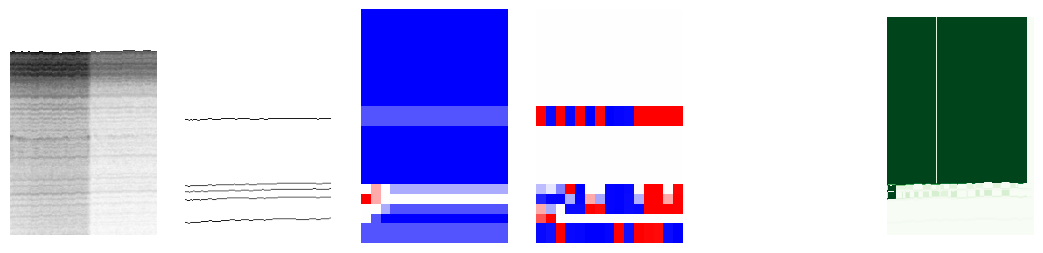

In [18]:
# print(files[6])
# test_load = np.load(files[6], None, allow_pickle=True)
test_load = np.load("../Seg_Featured_Data/Seg_Featured_Data_20120330_03_007_3.npy", None, allow_pickle=True)
# test_load = np.load("../Seg_Featured_Data/Seg_Featured_Data_20120330_01_022_5.npy", None, allow_pickle=True)
y, x, _ = test_load.shape
print(x, y)
plt.figure(figsize=(20,20))
plt.subplot(191),plt.imshow(test_load[:,:,0], cmap="Greys"),plt.axis('off')
plt.subplot(192),plt.imshow(test_load[:,:,1], cmap='Greys'),plt.axis('off')
# plt.subplot(193),plt.imshow(test_load[:,:,6], cmap='Greens', vmin=0, vmax=1),plt.axis('off')
plt.subplot(193),plt.imshow(test_load[:y//10-1,:x//10-1,2], cmap="bwr"),plt.axis('off')
plt.subplot(194),plt.imshow(test_load[:y//10-1,:x//10-1,3], cmap="bwr"),plt.axis('off')
# plt.subplot(195),plt.imshow(test_load[:y//10-1,:(x//10-1),4], cmap="bwr"),plt.axis('off')
# plt.subplot(196),plt.imshow(test_load[:,:,5]),plt.axis('off')
plt.subplot(196),plt.imshow(test_load[:,:,6], cmap='Greens', vmax=50),plt.axis('off')
# plt.subplot(198),plt.imshow(test_load[:,:,7], cmap='Greens'),plt.axis('off')
# plt.subplot(199),plt.imshow(test_load[:,:,8], cmap='Greens'),plt.axis('off')


(<AxesSubplot: >,
 (-0.5, 167.5, 24.5, -0.5))

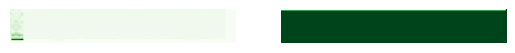

In [27]:
plt.subplot(121),plt.imshow(test_load[:y//10,:,7], cmap='Greens'),plt.axis('off')
plt.subplot(122),plt.imshow(test_load[:y//10,:,8], cmap='Greens'),plt.axis('off')

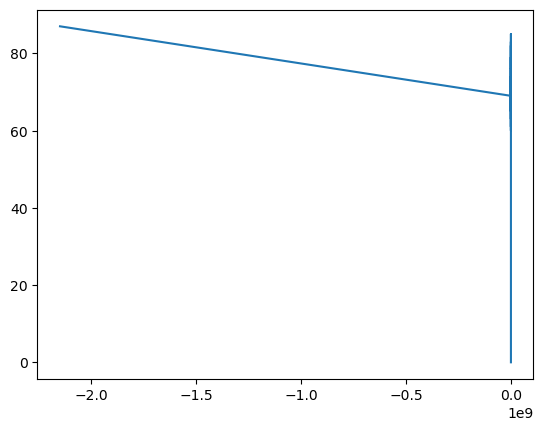

In [32]:
c = 100
plt.plot(test_load[:y//10,c,8], test_load[:y//10,c,7])

In [11]:
# FROM data_procssing
from scipy.interpolate import CubicSpline 
from scipy.fft import fft


def spatialFrequency(labels, splines, spatial_freq, wid):
    shaded_norms = (labels > 0).astype(int) 
    row, col = shaded_norms.shape
    # wid = 10
    s=0
    for spl in spatial_freq:
        for ((dist, ps),x) in spl:
            for i in range(x,x+wid):
                if i < col:
                    y = int(np.floor(splines[s](i)))
                    yo = int(y - 1)
                    # print(type(y), type(yo), type(i))
                    while yo >=0 and shaded_norms[yo, i] == 0:
                        yo -= 1
                    # yo = int(splines[ps](i))
                    if yo < 0:
                        yo = 0
                    shaded_norms[yo:y, i] = dist
        s +=1
    # Now we have an arrya with the distances filled in between layer
    # plt.imshow(shaded_norms, cmap='Greens')
    # return shaded_norms
    # We need to isolate the surface and the bedrock so we can remove those areas from the frequency
    #https://stackoverflow.com/questions/19125661/find-index-where-elements-change-value-numpy
    surface_borders = []
    bedrock_borders = []
    # print(shaded_norms.shape, shaded_norms.T.shape)
    for col in shaded_norms.T:
        chg_pts = np.where(col[:-1] != col[1:])[0] 
        # if there are no changes in a column then just put 0s
        if not len(chg_pts):  
            surface_borders.append(0)
            bedrock_borders.append(0)
            continue
        surface_borders.append(chg_pts[0])
        bedrock_borders.append(chg_pts[-1])

    # Calculate frequency along columns
    X = np.zeros_like(labels)
    freq = np.zeros_like(labels)
    i = 0
    for col in shaded_norms.T:
        # check if empty row
        if col[surface_borders[i]:bedrock_borders[i]].size:
            col_fft =np.abs(fft(col[surface_borders[i]:bedrock_borders[i]]))
            # X.append(col_fft[len(col_fft)//2:])
            # N = len(col_fft[len(col_fft)//2:])
            # freq.append(1./np.linspace(0, N, N))
            X[:(len(col_fft)-len(col_fft)//2), i] = col_fft[len(col_fft)//2:]
            N = len(col_fft[len(col_fft)//2:])
            freq[:N, i] = 1./np.linspace(0, N, N)    
            i += 1
    
    return X, freq, shaded_norms

In [16]:
# FROM Matfiles_SpatFreq
from skimage import measure

slice_labels = measure.label(test_load[:,:,1])
label_values = np.unique(slice_labels)[1:] #remove the 0 label
num_labels = len(label_values)
splines = []
domains = []
derivs = []

print("labels: ", num_labels)

for label_num in label_values:
    # isolate the label and skeletonize so that label is 1
    label_skeleton = (slice_labels[:,:] == label_num).astype(int)
    
    # Get every x,y every 10 columns
    row, col = label_skeleton.shape
    col_check = np.arange(0, col, 10)

    x, y = [], []
    for c in col_check:
        for r in range(row):
            if label_skeleton[r,c] == 1:
                if c in x: continue # if there are two lines then only take the top
                x.append(c) # get x indices
                y.append(r) # get y indices

    # create the cubic spline for the label
    if(len(x) > 1 and len(y) > 1):
        splines.append(CubicSpline(x,y))
        domains.append(x)
        derivs.append(splines[-1].derivative())

    # reset for next loop
    x = []
    y = [] 



X, Freq, shaded_norms = spatialFrequency(slice_labels, splines, test_load[:,:,6], 10)


labels:  5


TypeError: cannot unpack non-iterable numpy.float64 object

In [14]:
np.unique(test_load[:,:,1])

array([0., 1.])

In [6]:
# spat_range =np.unique(test_load[:,:,6])[1:-1]

vl, ct = np.unique(test_load[:,:,5], return_counts=True)
if len(ct)>1:
    num_bp = ct[1]
else:
    num_bp = 0

print("conected components (mean, std)", np.mean(test_load[:250//10-1,:250//10-1,2]), np.std(test_load[:250//10-1,:250//10-1,2]))
print("orientaiton (mean, std)", np.mean(test_load[:250//10-1,:250//10-1,3]), np.std(test_load[:250//10-1,:250//10-1,3]))
# print("mean orientaiton (mean, std)", np.mean(test_load[:250//10-1,:250//10-1,4]), np.std(test_load[:250//10-1,:250//10-1,4]))
print("num breakpoints",num_bp)
print("dist map (mean, std)", np.mean(test_load[:,:,6]), np.std(test_load[:,:,6]))

conected components (mean, std) 1.3420138888888888 0.5394558470516468
orientaiton (mean, std) -0.12631517958575234 0.8160832018203515
mean orientaiton (mean, std) -0.12631517958575234 0.8160832018203515
num breakpoints 4
dist map (mean, std) 22.491536 33.62555088560936


In [ ]:
# files = glob.glob("Seg_Featured_Data/*.npy")

max_len = 250*250+9
num_padded = 0
flattened_test_load = np.zeros((max_len, ))
print(flattened_test_load.shape)

for fl in files:
    test_load = np.load(fl, None, allow_pickle=True)
    y,x,_ = test_load.shape
    # Ignore depth 0
    # Keep all Depth 1
    #  if the x,y is less than 250x50 pad w 0s
    layers_depth = test_load[:,:,1]
    if x < 250:
        layers_depth = np.hstack((layers_depth, np.zeros((y, y-x))))
        num_padded +=1
    if y < 250:
        layers_depth = np.hstack((layers_depth, np.zeros((250-y, 250))))
    layers_depth = layers_depth.flatten()

    # Get the metrics from the other depths
    vl, ct = np.unique(test_load[:,:,5], return_counts=True)
    if len(ct)>1:
        num_bp = ct[1]
    else:
        num_bp = 0

    # print("conected components (mean, std)", np.mean(test_load[:y//10-1,:x//10-1,2]), np.std(test_load[:y//10-1,:x//10-1,2]))
    # print("orientaiton (mean, std)", np.mean(test_load[:y//10-1,:x//10-1,3]), np.std(test_load[:y//10-1,:x//10-1,3]))
    # print("mean orientaiton (mean, std)", np.mean(test_load[:250//10-1,:250//10-1,4]), np.std(test_load[:250//10-1,:250//10-1,4]))
    # print("num breakpoints",num_bp)
    # print("dist map (mean, std)", np.mean(test_load[:,:,6]), np.std(test_load[:,:,6]))


    data= np.append(layers_depth, [np.mean(test_load[:y//10-1,:x//10-1,2]), 
                                   np.mean(test_load[:y//10-1,:x//10-1,2]), np.std(test_load[:y//10-1,:x//10-1,2]),
                                    np.mean(test_load[:y//10-1,:x//10-1,3]), np.std(test_load[:y//10-1,:x//10-1,3]),
                                    num_bp,
                                    np.mean(test_load[:,:,6]), np.std(test_load[:,:,6])])


    flattened_test_load = np.vstack((flattened_test_load, data))

print(flattened_test_load.shape,flattened_test_load[0].shape, "num padded:", num_padded)

flattened_data = flattened_test_load[1:,:]
flattened_data.shape, len(labels)


In [14]:
np.append([1, 2, 3], [4, 5, 6,7, 8, 9])

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

### Tests with "bad" labels

In [49]:

X, y = make_blobs(n_samples=10000, n_features=10, centers=100,
    random_state=0)

X.shape, y.shape, type(X), type(y)

((10000, 10), (10000,), numpy.ndarray, numpy.ndarray)

In [90]:
group_kfold = GroupKFold(n_splits=6)
group_kfold.get_n_splits(X, y, [])

6

In [77]:
files = glob.glob("Seg_Featured_Data/*.npy")
max_len = 250*250*9
skip = 0
flattened_test_load = np.zeros((max_len, ))
print(flattened_test_load.shape)
for fl in files:
    test_load = np.load(fl, None, allow_pickle=True)
    t = test_load.flatten()
    t[t == np.inf] = 0.0
    t[t == -np.inf] = 0.0
    # print((t.shape[0]))
    if t.shape[0] < max_len:
        t= np.append(t,  [0]*(max_len-t.shape[0]), axis=0)
        skip += 1

    # flattened_test_load.append(np.float32(t))
    flattened_test_load = np.vstack((flattened_test_load, t))

print(flattened_test_load.shape,flattened_test_load[0].shape, "num padded:", skip)


(562500,)
(1085, 562500) (562500,) num padded: 155


In [82]:
flattened_test_load.T.shape[0]

562500

In [96]:
labels = [0]*flattened_test_load.T.shape[0]
m = flattened_test_load.T.shape[0]//2
print(type(labels), m)
labels[:10] = [1]*10
labels = np.array(labels)
# print((np.array(labels)).shape)
# np.unique(labels)

<class 'list'> 281250


In [97]:
X_train, X_test, y_train, y_test = train_test_split(flattened_test_load.T, labels, test_size=0.33, random_state=42)

In [98]:

clf = RandomForestClassifier(n_estimators=10, max_depth=None,
    min_samples_split=2, random_state=0)
# scores = cross_val_score(clf, np.float32(flattened_test_load.T), labels, cv=2, groups=group_kfold)
# scores.mean()

clf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=10, random_state=0)

In [99]:
clf.score(X_test, y_test)

0.9999838383838384

In [101]:

clfr = RandomForestRegressor(n_estimators=10, max_depth=None,
    min_samples_split=2, random_state=0)
# scores = cross_val_score(clf, np.float32(flattened_test_load.T), labels, cv=2, groups=group_kfold)
# scores.mean()

clfr.fit(X_train, y_train)


RandomForestRegressor(n_estimators=10, random_state=0)

In [102]:
clfr.score(X_test,y_test)

-0.1600201837877009

### Clip


In [ ]:
# from PIL import Image
# import requests
# from transformers import AutoProcessor, CLIPVisionModel

# model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
# processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)

# inputs = processor(images=image, return_tensors="pt")

# outputs = model(**inputs)
# last_hidden_state = outputs.last_hidden_state
# pooled_output = outputs.pooler_output  # pooled CLS states